<a href="https://colab.research.google.com/github/OH1107/edu/blob/master/fintech/20200918_PCC_DataLab%26Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 데이터랩의 검색어 트렌드의 주가 영향력 분석


## reference (parameters)
- 네이버 디벨로퍼 가입
- 어플리케이션 등록
- https://developers.naver.com/docs/datalab/search/#%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0

In [1]:
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# 네이버 데이터랩 API code

- 라이브러리 호출

In [1]:
from pandas.io import gbq

import os
import sys
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
fm._rebuild()

mpl.rcParams['axes.unicode_minus'] = False

# makeQry 함수 정의
- CJ ENM의 마케팅적 이벤트가 될수 있었던 요소
  - 2019년 작품 키워드 설정 (극한직업, 사바하, 걸캅스, 백두산, 나쁜녀석들)
  - '기생충'은 다른 영화들에 비해 데이터랩 검색량이 너무 많아 비교가 어려우므로 키워드에서 제외
- 해당 키워드로 데이터 랩에 검색 가능토록 __body 값(json 형태)__으로 변환하는 함수 정의

In [2]:
keywords=[['극한직업'],['사바하'],['걸캅스'],['백두산'],['나쁜녀석들']]

def makeQry(keywords=[],sdate='',edate='',tunit='date'):
  res = []
  for word in keywords:
    dict={'groupName':word[0], 'keywords':word}
    res.append(dict)
  

  rdict={"startDate":sdate,
         "endDate":edate,
         "timeUnit":tunit,
         "keywordGroups":res}
  return json.dumps(rdict, ensure_ascii=False)

# Mynsearch 함수 정의
- `makeQry`함수로 만들어진 body값을 사용하여 __raw data__를 불러오는 함수 정의

In [3]:
def Mynsearch(keywords=[],sdate='',edate='',tunit='date'):
  client_id = "GjOIh9f0eos4ZlO0MuPJ"
  client_secret = "6D0DNFKlWz"
  url = "https://openapi.naver.com/v1/datalab/search";
 
  body = makeQry(keywords, sdate, edate, tunit)

  request = urllib.request.Request(url)
  request.add_header("X-Naver-Client-Id",client_id)
  request.add_header("X-Naver-Client-Secret",client_secret)
  request.add_header("Content-Type","application/json")
  response = urllib.request.urlopen(request, data=body.encode("utf-8"))
  rescode = response.getcode()
  if (rescode==200):
    response_body = response.read()
    res=response_body.decode('utf-8')
    #print(res)
  else:
    res='error'
    print("Error Code:" + rescode)
  return res

# MyDataLab 함수 정의
- `Mynsearch` 함수로 불러온 raw_data를 DataFrame화 시키는 함수 정의

In [4]:
def MyDataLab(keywords=[],sdate='',edate='',tunit='date'):
  # 네이버 데이터랩 서치
  res=Mynsearch(keywords, sdate, edate, tunit)

  # 데이터 추출을 위한 json
  jdata=json.loads(res)

  # 테이블 머지를 위한 기초테이블
  maindf=pd.DataFrame()

  # 키워드별로 컬럼명 지정
  i =0
  for words in keywords:
    pdata=jdata['results'][i]['data']
    i += 1
    df=pd.DataFrame.from_dict(pdata)
    df.columns=["period",words[0]]
    df.set_index("period", inplace=True)
    maindf=pd.merge(maindf, df, how='outer', left_index=True, right_index=True)

  return maindf

In [5]:
mdf=MyDataLab(keywords, '2019-01-01', '2020-08-30', 'date')
mdf.head()

,극한직업,사바하,걸캅스,백두산,나쁜녀석들
period,,,,,
2019-01-01,0.51273,0.03758,0.01178,0.14547,0.15669
2019-01-02,0.59014,0.03655,0.01355,0.11658,0.14220
2019-01-03,0.57528,0.02870,0.00981,0.10892,0.11350
2019-01-04,5.09767,0.02758,0.01552,0.10172,0.12453
2019-01-05,1.13232,0.03300,0.01299,0.08695,0.14248


# MyDBLab 함수 정의
- 본 사용자 정의 함수는 3가지 기능 수행
  1. `MyDataLab`으로부터 DataFrame 불러오기
  2. `BigQuery`로부터 주식데이터를 불러오기
  3. 1번과 2번 데이터를 merge 및 선형보간

In [6]:
def MyDBLab(keywords=[], sdate='', edate='', tunit='date', Stock_data_location=''):
  # 데이터랩 사용자 정의 함수
  mdf=MyDataLab(keywords, sdate ,edate, tunit)
  
  # 쿼리문에 대입하기 위한 변수 선언
  sdaycode=sdate.replace('-','')
  edaycode=edate.replace('-','')
  
  # BigQuery로 부터 Stock데이터 호출
  project_id = 'groovy-ego-286903'
  sql = "SELECT SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL FROM "+Stock_data_location+" WHERE SDAY >="+sdaycode+" and SDAY<="+edaycode+" ORDER BY SDAY asc"
  
  company_df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

  # Stock데이터와 데이터랩 데이터를 merge시키기 위한 index작업
  company_df['period']=[str(i)[:4]+'-'+str(i)[4:-2]+'-'+str(i)[-2:] for i in company_df['SDAY']]
  df_stock=company_df.set_index('period')
  
  # 그래프를 호출하기 위해 all_df로 merge
  df=pd.merge(df_stock, mdf, how='outer', left_index=True, right_index=True)

  # 선형보간
  all_df=df.interpolate() 

  return all_df

In [7]:
all_df=MyDBLab(keywords, '2019-01-01', '2020-08-30', 'date', 'Stock_data.cj_stock')

In [8]:
all_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL,극한직업,사바하,걸캅스,백두산,나쁜녀석들
period,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0.51273,0.03758,0.01178,0.14547,0.15669
2019-01-02,20190102.0,202700.000000,196500.000000,202900.0,196500.0,58208.000000,0.59014,0.03655,0.01355,0.11658,0.14220
2019-01-03,20190103.0,196700.000000,191200.000000,197500.0,190200.0,69363.000000,0.57528,0.02870,0.00981,0.10892,0.11350
2019-01-04,20190104.0,191200.000000,191500.000000,192500.0,187400.0,70378.000000,5.09767,0.02758,0.01552,0.10172,0.12453
2019-01-05,20190105.0,191666.666667,194133.333333,194800.0,189000.0,68375.333333,1.13232,0.03300,0.01299,0.08695,0.14248


# pltDBLab 함수 정의
- `MyDBLab` 데이터를 시각화 시키는 함수

```python
  # 영화 개봉일을 수직선으로 표현 
  movie_release_date = {'극한직업':['2019-01-23','blue'],
                      '사바하':['2019-02-20','orange'],
                      '걸캅스':['2019-05-09','green'],
                      '나쁜녀석들':['2019-09-11','purple'],
                      '백두산':['2019-12-19','red']}
  
  global location_num
  location_num = 0
  
  for movie, date_color in movie_release_date.items():
    # 수직선 출력
    ax1.axvline(x=date_color[0], label=movie, color=date_color[1], linestyle='--', linewidth=2)

    # 수직선 옆 text 출력
    idx=list(all_df.index)
    temp=location_num
    location_num=idx.index(date_color[0])
    if (temp != 0 and location_num-temp < 30):
      plt.text(location_num+2,245000, "{} 개봉".format(movie))
    else:
      plt.text(location_num+2,240000, "{} 개봉".format(movie))
```
- 해당 코드는 각 영화의 개봉일을 표기하기 위함이므로 평소엔 주석처리를 해놓는다.

In [9]:
def pltDBLab(all_df, keywords, xstep=30, ptitle='CJ ENM 영화와 주가의 상관도'):
  xtic=np.arange(0, len(all_df.index), step=xstep)
  xdays=[all_df.index[i] for i in xtic]

  set_df=pd.DataFrame()
  for words in keywords:
    set_df=pd.concat((set_df, all_df[words]), axis=1)


  # X 축을 공유하고 Y 축을 이중으로 사용
  plt.rcParams["figure.figsize"] = (16,8)

  fig, ax1= plt.subplots()

  # 주가 그래프
  ax1.plot(all_df['CLOSEP'], c='k')

  """
  # 영화 개봉일을 수직선으로 표현 
  movie_release_date = {'극한직업':['2019-01-23','blue'],
                      '사바하':['2019-02-20','orange'],
                      '걸캅스':['2019-05-09','green'],
                      '나쁜녀석들':['2019-09-11','purple'],
                      '백두산':['2019-12-19','red']}
  
  global location_num
  location_num = 0
  
  for movie, date_color in movie_release_date.items():
    # 수직선 출력
    ax1.axvline(x=date_color[0], label=movie, color=date_color[1], linestyle='--', linewidth=2)

    # 수직선 옆 text 출력
    idx=list(all_df.index)
    temp=location_num
    location_num=idx.index(date_color[0])
    if (temp != 0 and location_num-temp < 30):
      plt.text(location_num+2,245000, "{} 개봉".format(movie))
    else:
      plt.text(location_num+2,240000, "{} 개봉".format(movie))
  """

  ax1.set_ylabel('Price')
  plt.xticks(xtic, xdays, rotation=45)

  # 네이버 데이터 랩 영화 검색량 그래프
  ax2=ax1.twinx()
  ax2.set_ylabel("Ratio")

  # 그래프 출력, 조정
  set_df.plot(ax=ax2)

  plt.title(ptitle, fontdict={'fontsize':20})
  plt.legend()
  plt.tight_layout()
  plt.show()

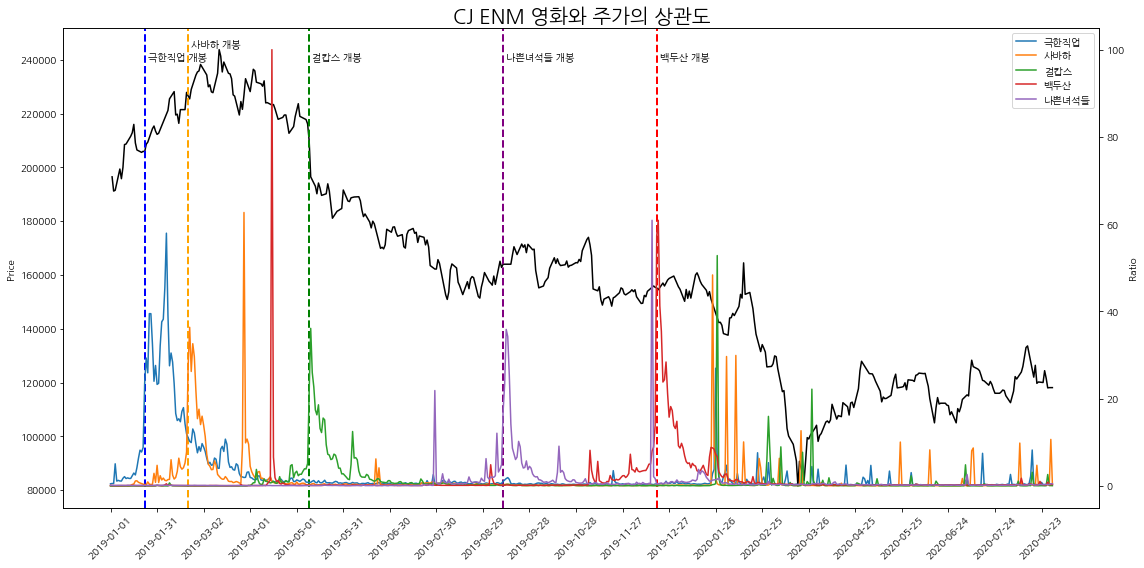

In [ ]:
pltDBLab(all_df, keywords, 30, 'CJ ENM 영화와 주가의 상관도')

# 영화 개봉이 주가에 주는 영향 분석 에시
- 영화는 '극한직업'을 예시로 함
- 개봉일자 전후 한달의 데이터를 시각화

In [39]:
keywords = [['극한직업']]
movie1_df=MyDBLab(keywords, '2019-01-15', '2019-02-15', 'date', 'Stock_data.cj_stock')

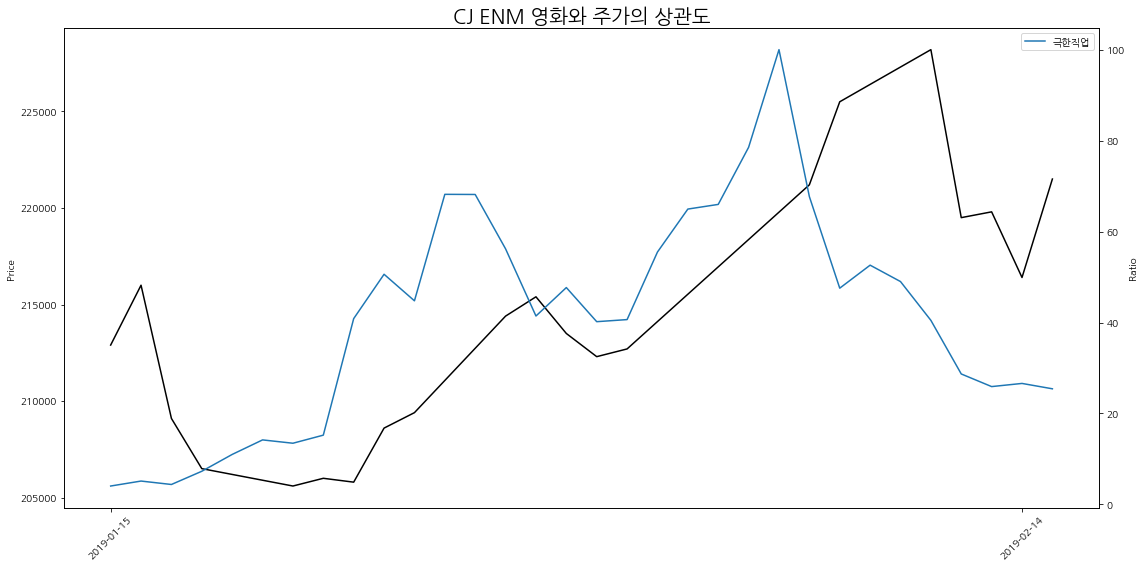

In [40]:
pltDBLab(movie1_df, keywords, 30, 'CJ ENM 영화와 주가의 상관도')

### 통계량 분석
#### 피어슨 상관계수
* 피어슨 상관 계수(Pearson Correlation Coefficient ,PCC)
* 두 변수 X 와 Y 간의 선형 상관 관계를 계량화한 수치
* 피어슨 상관 계수는 코시-슈바르츠 부등식에 의해 +1과 -1 사이의 값을 가짐
* +1은 완벽한 양의 선형 상관 관계
* 0은 선형 상관 관계 없음
* -1은 완벽한 음의 선형 상관 관계

In [95]:
check_df=movie1_df[['CLOSEP','극한직업']]
check_df.corr()

,CLOSEP,극한직업
CLOSEP,1.000000,0.390641
극한직업,0.390641,1.000000


- 낮은 상관관계를 보이고 있다.
- 그렇다면 극한직업의 그래프를 5일 쉬프트 해서 비교해보자.

In [110]:
check_df.columns=['CLOSEP','극한직업_shift']
shift_df=check_df['극한직업_shift'].shift(5,fill_value=0)
shift_df.head(10)

period
2019-01-15     0.00000
2019-01-16     0.00000
2019-01-17     0.00000
2019-01-18     0.00000
2019-01-19     0.00000
2019-01-20     4.04935
2019-01-21     5.14039
2019-01-22     4.38706
2019-01-23     7.29230
2019-01-24    10.99330
Name: 극한직업_shift, dtype: float64

In [111]:
shift_all=pd.merge(movie1_df,shift_df,how="inner",left_index=True,right_index=True)
print(shift_all.head(10))
print("*"*40)
print(shift_all[['CLOSEP','극한직업_shift']].corr())

                  SDAY          OPENP  ...      극한직업  극한직업_shift
period                                 ...                      
2019-01-15  20190115.0  211400.000000  ...   4.04935     0.00000
2019-01-16  20190116.0  213000.000000  ...   5.14039     0.00000
2019-01-17  20190117.0  214800.000000  ...   4.38706     0.00000
2019-01-18  20190118.0  208500.000000  ...   7.29230     0.00000
2019-01-19  20190119.0  207633.333333  ...  10.99330     0.00000
2019-01-20  20190120.0  206766.666667  ...  14.18881     4.04935
2019-01-21  20190121.0  205900.000000  ...  13.45806     5.14039
2019-01-22  20190122.0  205500.000000  ...  15.23499     4.38706
2019-01-23  20190123.0  205500.000000  ...  40.86066     7.29230
2019-01-24  20190124.0  205300.000000  ...  50.60997    10.99330

[10 rows x 8 columns]
****************************************
             CLOSEP  극한직업_shift
CLOSEP      1.00000     0.81211
극한직업_shift  0.81211     1.00000


- 5일을 쉬프트하고 상관관계를 분석해보니 0.812이라는 강한 양의 상관관계가 나타난다.
---

# shiftGraph 함수 정의
- 위에서 만든 shift_all 테이블을 입력하면 그래프를 출력하는 함수를 만들도록 하겠다.

In [136]:
def shiftGraph(shift_all, baseCol ,ptitle='shift 결과',xstep=10, shiftday=10):

    xtic=np.arange(0,len(shift_all.index),step=10)
    xdays=[shift_all.index[i] for i in xtic]

    col_name = baseCol + '_shift'
    sdf=shift_all[col_name]#,'사바하','걸캅스','나쁜녀석들','백두산'
    
    plt.rcParams["figure.figsize"]=(12,6)
    
    fig, ax1=plt.subplots()

    plt.xticks(xtic,xdays,rotation=45)
    
    ax1.plot(shift_all['CLOSEP'] ,color='black')
    ax1.set_ylabel("Price")
    ax2=ax1.twinx()
    ax2.set_ylabel("Ratio")
    
    sdf.plot(ax=ax2)
    
    plt.title(ptitle)
    plt.legend()
    fig.tight_layout()
    plt.show()

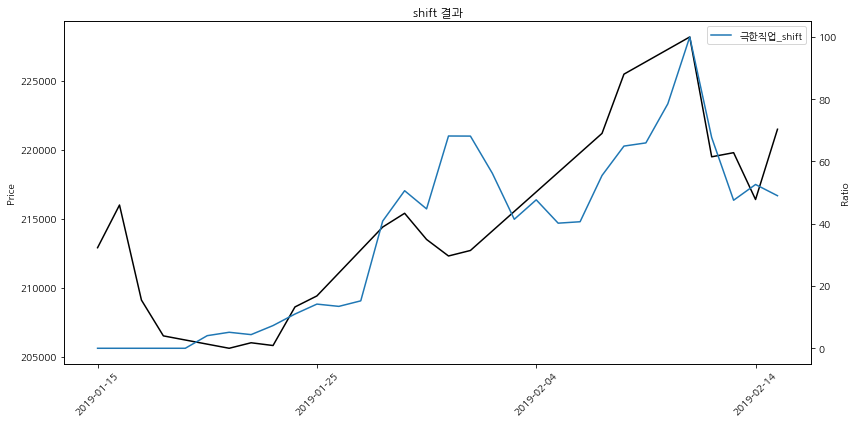

In [137]:
shiftGraph(shift_all, '극한직업', 'shift 결과')

# shiftLab 함수 정의
- all_df 데이터를 shift_all 데이터로 정제하는 작업과 그 데이터를 `shiftGraph` 함수로 보내 시각화까지 진행하도록 한다.

In [138]:
def shiftLab(all_df , baseCol='극한직업', shiftday=5):

  # 기존 정보상의 상관분석 (효과가 적음)
  check_df=all_df[['CLOSEP',baseCol]]
  print("*"*40)
  print(check_df.describe())
  print("*"*40)
  print(check_df.corr())

  # 쉬프트 정보 작성
  check_df.columns=['CLOSEP', baseCol+'_shift']
  shift_df=check_df[''+baseCol+'_shift'].shift(shiftday, fill_value=0)

  # 기존 데이터와 병합
  shift_all = pd.merge(all_df, shift_df, how='inner', left_index=True, right_index=True)
  check5=shift_all[['CLOSEP',baseCol+'_shift']]

  # 새로운 상관분석
  print("*"*40)
  print(check5.corr())
  print("*"*40)
  
  shiftGraph(shift_all, baseCol)

****************************************
              CLOSEP        극한직업
count      32.000000   32.000000
mean   214832.812500   40.700198
std      6635.355887   24.167937
min    205600.000000    4.049350
25%    209325.000000   22.878787
50%    214258.333333   41.146570
75%    219570.833333   55.676147
max    228200.000000  100.000000
****************************************
          CLOSEP      극한직업
CLOSEP  1.000000  0.390641
극한직업    0.390641  1.000000
****************************************
             CLOSEP  극한직업_shift
CLOSEP      1.00000     0.81211
극한직업_shift  0.81211     1.00000
****************************************


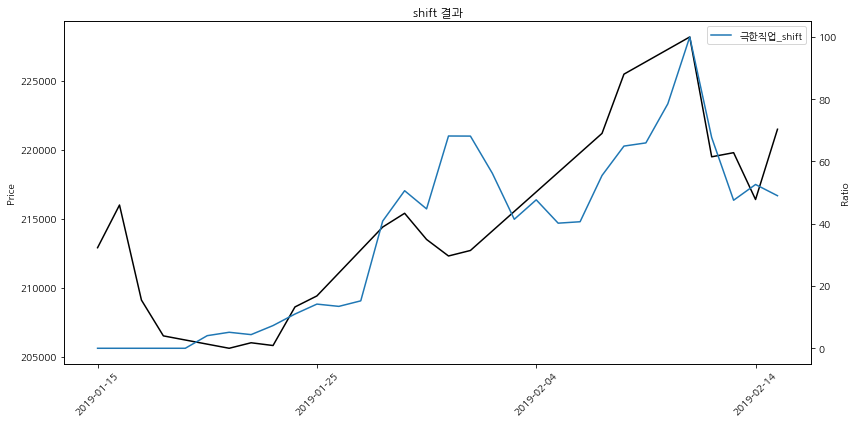

In [139]:
shiftLab(movie1_df, '극한직업', 5)

- 극한직업이 아닌 다른 키워드 '사바하'를 적용해보자.

In [140]:
keywords=[['사바하']]
movie2_df=MyDBLab(keywords, '2019-02-15', '2019-03-15', 'date','Stock_data.cj_stock')
movie2_df.head()

,SDAY,OPENP,CLOSEP,HIGHP,LOWP,VOL,사바하
period,,,,,,,
2019-02-15,20190215.0,219700.000000,221500.0,222600.0,216700.0,157293.000000,12.20461
2019-02-16,20190216.0,220333.333333,221500.0,223200.0,217800.0,120934.333333,10.61850
2019-02-17,20190217.0,220966.666667,221500.0,223800.0,218900.0,84575.666667,11.55870
2019-02-18,20190218.0,221600.000000,221500.0,224400.0,220000.0,48217.000000,14.51553
2019-02-19,20190219.0,222000.000000,227900.0,235000.0,220800.0,226956.000000,21.48427


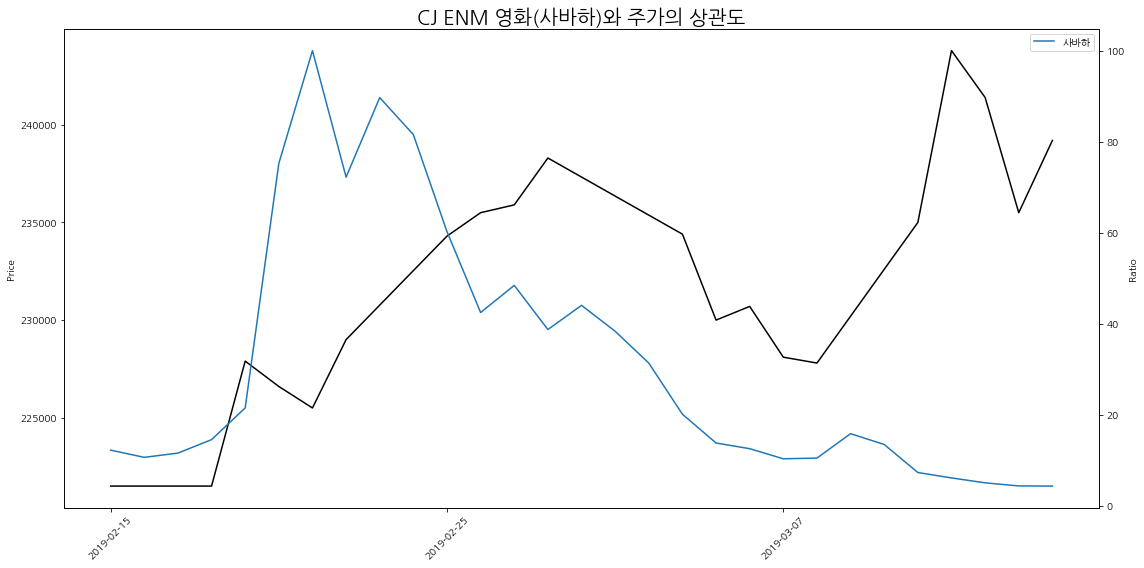

In [141]:
pltDBLab(movie2_df, keywords, 10, "CJ ENM 영화(사바하)와 주가의 상관도")

- shift값을 5를 주고 확인해보자.



****************************************
              CLOSEP         사바하
count      29.000000   29.000000
mean   231725.862069   31.584496
std      6028.340535   28.601482
min    221500.000000    4.310830
25%    227900.000000   10.618500
50%    232533.333333   15.825840
75%    235500.000000   44.022350
max    243800.000000  100.000000
****************************************
          CLOSEP       사바하
CLOSEP  1.000000 -0.078005
사바하    -0.078005  1.000000
****************************************
             CLOSEP  사바하_shift
CLOSEP     1.000000   0.461185
사바하_shift  0.461185   1.000000
****************************************


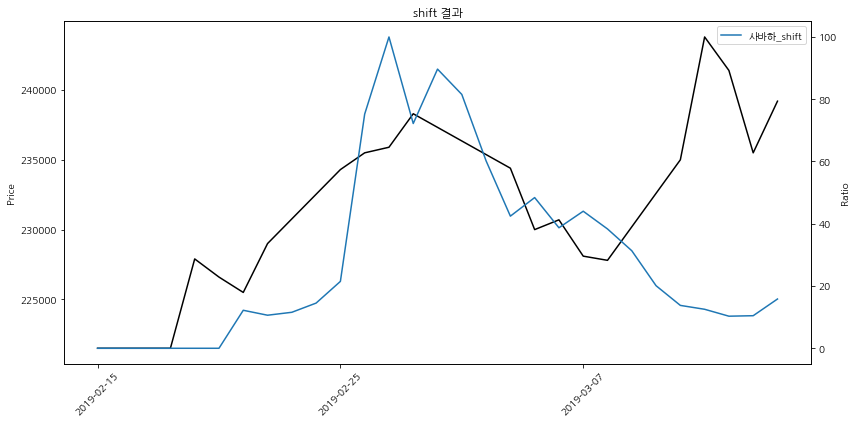

In [142]:
shiftLab(movie2_df, '사바하', 6)

- 영화 '사바하'의 경우 상관관계가 0에 가까웠던 상태에서 5일을 shift한 결과 약 0.4의 상관관계가 나타난다.  
- 그러나 0.4 또한 약한 상관관계이므로 크게 영향을 끼치지 못한 것으로 판단된다.
